In [8]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import rioxarray
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, timedelta
import calendar

# Cho phần huấn luyện mô hình
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv2D


In [9]:
# Cell 2: Global Parameters and File Info
HEIGHT = 90
WIDTH = 250

# Danh sách tên biến: phần đầu tiên dành cho AWS (Precipitation), sau đó là các biến từ ERA5.
TMP_NAMES = ['AWS', 'CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV',
             'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF',
             'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']

# FILE_NAME: đối với Precipitation/AWS và các biến khác từ ERA5 (nếu cần dùng sau này)
FILE_NAME = [['Precipitation', 'AWS']]
for i in range(1, len(TMP_NAMES)):
    FILE_NAME.append(['ERA5', TMP_NAMES[i]])


In [10]:
# Cell 3: Define Function to Get Precipitation Data for a Given Timestamp
def get_precipitation_data(year, month, day, hour):
    """
    Đọc dữ liệu mưa từ file Precipitation/AWS theo định dạng đã cho.
    Trả về mảng numpy dạng (HEIGHT, WIDTH) nếu tồn tại file, ngược lại trả về None.
    """
    file_path = f'DATA_SV/Precipitation/AWS/{year}/{month:02d}/{day:02d}/AWS_{year}{month:02d}{day:02d}{hour:02d}0000.tif'
    path = Path(file_path)
    if path.is_file():
        try:
            dataset = rioxarray.open_rasterio(file_path)
            data = dataset[0].values
            # Xử lý các giá trị không hợp lệ: thay thế -np.inf, np.inf, NaN bằng 0 (hoặc giá trị phù hợp)
            data = np.where(~np.isfinite(data), 0, data)
            return data
        except Exception as e:
            print(f"Error reading precipitation file {file_path}: {e}")
            return None
    else:
        return None


In [11]:
# Cell 4: Build Training Data from Year 2019
# Chỉ lấy dữ liệu từ các tháng 4 và 10 của năm 2019

X_train_list = []
Y_train_list = []

train_year = 2019
for month in [4, 10]:
    num_days = calendar.monthrange(train_year, month)[1]
    for day in range(1, num_days+1):
        for hour in range(24):
            current_time = datetime(train_year, month, day, hour)
            # Xây dựng input: 3 frame tại các mốc T-3, T-2, T-1
            input_times = [current_time - timedelta(hours=3),
                           current_time - timedelta(hours=2),
                           current_time - timedelta(hours=1)]
            # Target: frame tại T+6
            target_time = current_time + timedelta(hours=6)
            
            frames = []
            valid = True
            for t in input_times:
                frame = get_precipitation_data(t.year, t.month, t.day, t.hour)
                if frame is None:
                    valid = False
                    break
                frames.append(frame)
            target_frame = get_precipitation_data(target_time.year, target_time.month, target_time.day, target_time.hour)
            if target_frame is None:
                valid = False
                
            if valid:
                # Chuyển mỗi frame thành (HEIGHT, WIDTH, 1)
                frames_stack = np.stack([f.reshape(HEIGHT, WIDTH, 1) for f in frames], axis=0)
                X_train_list.append(frames_stack)
                Y_train_list.append(target_frame.reshape(HEIGHT, WIDTH, 1))
                
print(f"Số mẫu thu được từ năm 2019: {len(X_train_list)}")

if len(X_train_list) > 0:
    X_train = np.array(X_train_list, dtype=np.float32)
    Y_train = np.array(Y_train_list, dtype=np.float32)
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
else:
    print("Không có mẫu huấn luyện nào được thu thập!")


Số mẫu thu được từ năm 2019: 1228
X_train shape: (1228, 3, 90, 250, 1)
Y_train shape: (1228, 90, 250, 1)


In [12]:
# Cell 5: Build a ConvLSTM Model for Nowcasting
# Input: (time_steps, HEIGHT, WIDTH, channels) với time_steps = 3, channels = 1

input_shape = (3, HEIGHT, WIDTH, 1)

inputs = Input(shape=input_shape)
# Lớp ConvLSTM2D với 32 filters, kernel 3x3, trả về một frame (return_sequences=False)
x = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False, activation='relu')(inputs)
x = BatchNormalization()(x)
# Lớp Conv2D để chuyển đổi output thành map mưa 1 kênh, sử dụng activation 'sigmoid'
outputs = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

model = Model(inputs, outputs)
# Sử dụng optimizer Adam với learning_rate thấp hơn nếu cần (vd: 1e-4)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 90, 250, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 90, 250, 32)    │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 250, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 250, 1)     │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,561 (150.63 KB)

 Trainable params: 38,497 (150.38 KB)

 Non-trainable params: 64 (256.00 B)

In [13]:
# Cell 6: Train the Model with 2019 Data
if 'X_train' in globals() and X_train.shape[0] > 0:
    history = model.fit(X_train, Y_train, epochs=10, batch_size=8, validation_split=0.1)
else:
    print("Không có dữ liệu huấn luyện, vui lòng kiểm tra lại quá trình thu thập data.")


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 103s 720ms/step - loss: 0.2740 - val_loss: 0.2313
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 715ms/step - loss: 0.2051 - val_loss: 0.1476
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 719ms/step - loss: 0.1213 - val_loss: 0.0808
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 715ms/step - loss: 0.0806 - val_loss: 0.0485
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 721ms/step - loss: 0.0636 - val_loss: 0.0371
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 715ms/step - loss: 0.0478 - val_loss: 0.0338
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 717ms/step - loss: 0.0488 - val_loss: 0.0312
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 714ms/step - loss: 0.0423 - val_loss: 0.0293
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 714ms/step - loss: 0.0453 - val_loss: 0.0282
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 715ms/step - loss: 0.0420 - val_loss: 0.0270


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Đánh giá cho mốc thời gian 2020-04-15 18:00:
MSE: 0.002616959
MAE: 0.050315756


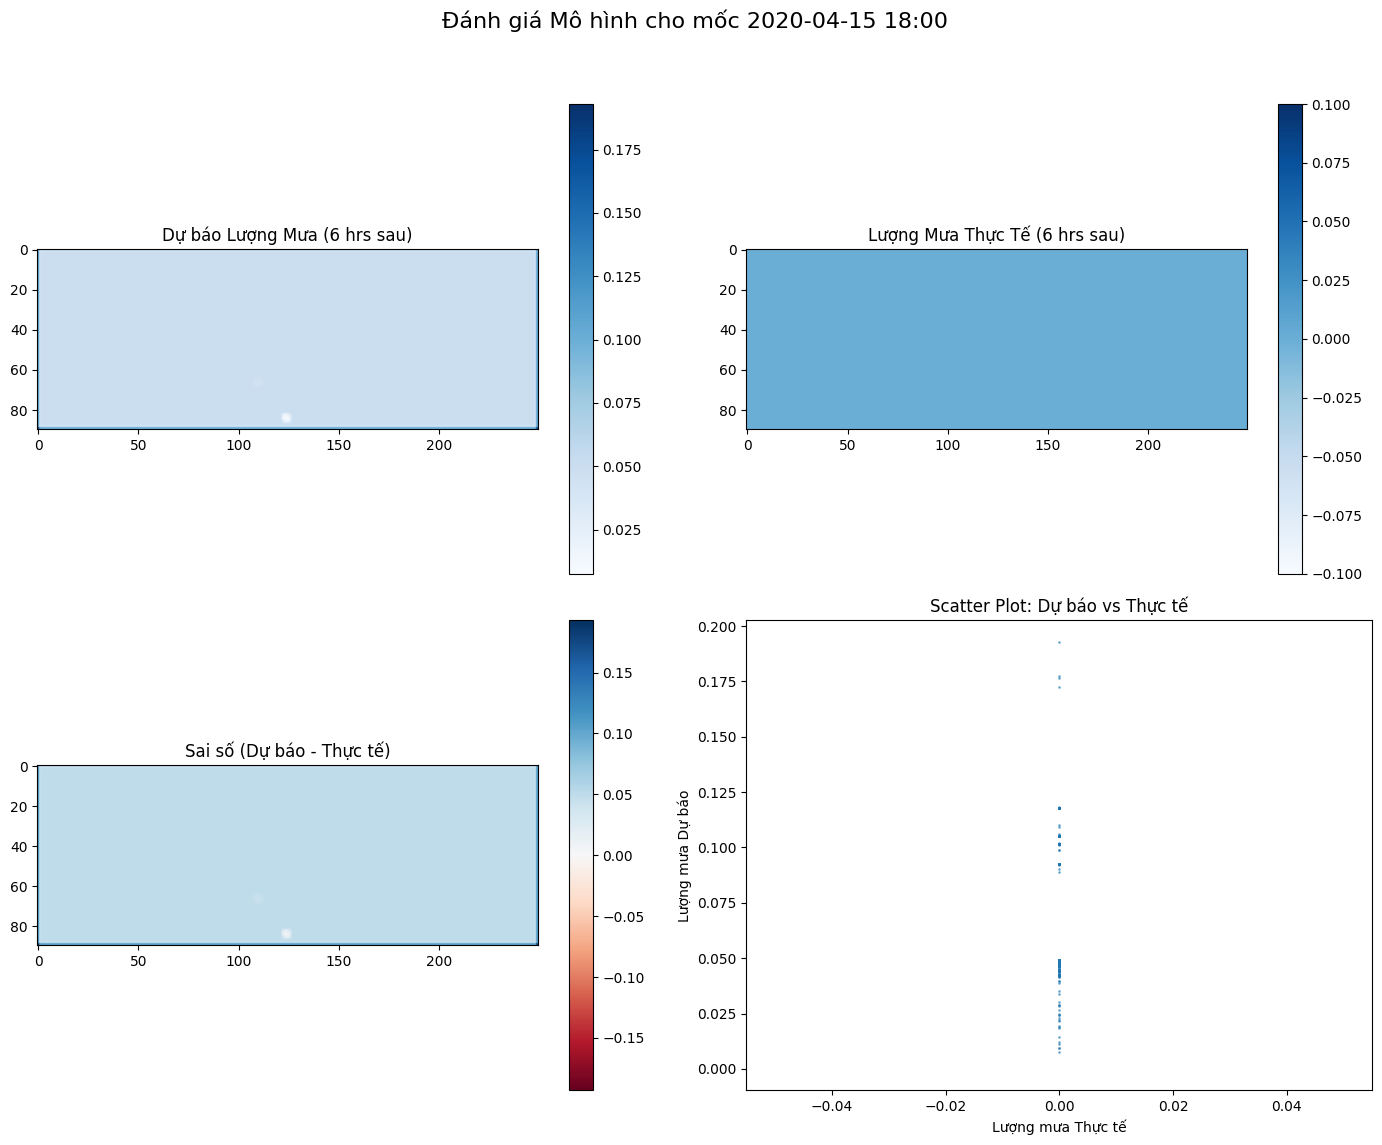

In [14]:
# Cell 7: Build Test Data from Year 2020, Perform Prediction, Evaluate, and Plot Comparisons

# Chọn mốc thời gian test: ví dụ ngày 15 tháng 4 năm 2020, giờ 12:00
test_year = 2020
test_month = 4    # Bạn có thể thử test_month = 10 nếu muốn
test_day = 15
test_hour = 12
current_time_test = datetime(test_year, test_month, test_day, test_hour)

# Xây dựng input: lấy 3 frame từ T-3, T-2, T-1
input_times_test = [current_time_test - timedelta(hours=3),
                    current_time_test - timedelta(hours=2),
                    current_time_test - timedelta(hours=1)]
frames_test = []
valid_test = True
for t in input_times_test:
    frame = get_precipitation_data(t.year, t.month, t.day, t.hour)
    if frame is None:
        valid_test = False
        print(f"Thiếu dữ liệu tại thời điểm {t.strftime('%Y-%m-%d %H:%M')}")
        break
    frames_test.append(frame)
    
# Target (Ground Truth): Frame tại T+6
target_time_test = current_time_test + timedelta(hours=6)
actual_test = get_precipitation_data(target_time_test.year, target_time_test.month, target_time_test.day, target_time_test.hour)

if not valid_test or actual_test is None:
    print("Không đủ dữ liệu cho mốc thời gian thử nghiệm từ năm 2020. Vui lòng chọn mốc thời gian khác.")
else:
    # Chuẩn bị input cho mô hình: reshape mỗi frame về (HEIGHT, WIDTH, 1)
    test_input_sequence = np.stack([f.reshape(HEIGHT, WIDTH, 1) for f in frames_test], axis=0)
    test_input_sequence = np.expand_dims(test_input_sequence, axis=0)  # shape: (1, 3, HEIGHT, WIDTH, 1)

    # Thực hiện dự báo
    predicted_test = model.predict(test_input_sequence)[0, :, :, 0]  # shape: (HEIGHT, WIDTH)

    # Tính các chỉ số đánh giá: Mean Squared Error (MSE) và Mean Absolute Error (MAE)
    mse_val = np.mean((predicted_test - actual_test)**2)
    mae_val = np.mean(np.abs(predicted_test - actual_test))

    print(f"Đánh giá cho mốc thời gian {target_time_test.strftime('%Y-%m-%d %H:%M')}:")
    print("MSE:", mse_val)
    print("MAE:", mae_val)

    # Tính bản đồ sai số (difference map)
    diff_map = predicted_test - actual_test

    # Vẽ các bản đồ và biểu đồ so sánh
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # 1. Bản đồ lượng mưa dự báo
    im0 = axes[0, 0].imshow(predicted_test, cmap='Blues')
    axes[0, 0].set_title("Dự báo Lượng Mưa (6 hrs sau)")
    fig.colorbar(im0, ax=axes[0, 0])

    # 2. Bản đồ lượng mưa thực tế
    im1 = axes[0, 1].imshow(actual_test, cmap='Blues')
    axes[0, 1].set_title("Lượng Mưa Thực Tế (6 hrs sau)")
    fig.colorbar(im1, ax=axes[0, 1])

    # 3. Bản đồ sai số (predicted - actual)
    max_abs_diff = np.max(np.abs(diff_map))
    im2 = axes[1, 0].imshow(diff_map, cmap='RdBu', vmin=-max_abs_diff, vmax=max_abs_diff)
    axes[1, 0].set_title("Sai số (Dự báo - Thực tế)")
    fig.colorbar(im2, ax=axes[1, 0])

    # 4. Scatter plot: từng điểm (pixel) dự báo vs. thực tế
    axes[1, 1].scatter(actual_test.flatten(), predicted_test.flatten(), alpha=0.5, s=1)
    axes[1, 1].plot([actual_test.min(), actual_test.max()],
                    [actual_test.min(), actual_test.max()],
                    'k--', lw=2)
    axes[1, 1].set_xlabel("Lượng mưa Thực tế")
    axes[1, 1].set_ylabel("Lượng mưa Dự báo")
    axes[1, 1].set_title("Scatter Plot: Dự báo vs Thực tế")

    plt.suptitle(f"Đánh giá Mô hình cho mốc {target_time_test.strftime('%Y-%m-%d %H:%M')}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
